<a href="https://colab.research.google.com/github/Mohrezasharifi/AI_Engineering_NYC-Taxi-Dataset/blob/main/CSC8101_spark_coursework_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [CSC8101] Engineering for AI - 2025 Spark Coursework
*Submitted by: Mohammmad Reza Sharifi (230533851) | Module Lead: Dr. Varun Ojha and Dr. Iain*

# **Introduction:**

The **New York City (NYC) Taxi Dataset** is a rich and comprehensive collection of taxi trip records, capturing detailed information about millions of trips across the city. This dataset includes attributes such as pickup/dropoff locations, trip distances, passenger counts, fares, and timestamps, making it an invaluable resource for analyzing urban transportation patterns, optimizing taxi operations, and improving city planning.

**Overiew of the Dataset:**

*Trips Dataset:*

Contains records of individual taxi trips, including pickup/dropoff times, locations, distances, fares, and passenger counts.

*Zones Dataset:*

Provides mapping of location IDs to zone names (e.g., Manhattan, Brooklyn), enabling spatial analysis of trip origins and destinations.

*Dataset Sizes:*

Small (S): 2.9 million rows (July 2021 data).

Medium (M): 15.57 million rows (2021 full-year data).

Large (L): 41.95 million rows (2020-2021 data).

Extra Large (XL): Combined data from 2019 and 2020-2021.

XXL: Largest dataset, combining all available data.


**Disclaimer:**

*The report has mainly focused on the S dataset as the machine was confident enough to run it wihtout crashing or refusing any Spark connection. But the pipeline could implemented on S, M, and L datasets with their relevant time taken for execution.* Plus, the dataset has been mounted by the driver shared by the module coordinator through Google Drive. So, having the Google Drive and mounting it properly should be easy to still go ahead with the project.

The following codeblock is used to mount the google colab instance to the google drive to access the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 0 - Reading the data from the dataset

The code below is used to read the data after the Google Drive is mounted. In my case, the dataset resides in (/content/drive/MyDrive/AdvancedAI_Data/) with files having .parquet extension. The dataset have been provided in this format.

In [2]:
%pip install findspark


**Installing and Importing the important libraries**
You may use %pip install packagename if you get an error that says package has not been found.



In [3]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
import pandas as pd
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, expr, percentile_approx

# Initializing Spark session
spark = SparkSession.builder.appName("NYC Taxi Data Cleaning")
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]")\
    .config("spark.executor.memory", "8g")\
    .config("spark.driver.memory", "4g")\
    .getOrCreate()

This code snippet is to import the dataset from the Drive and all sizes of the dataset have been imported.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/NewcastleComputingScience/csc8101-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S'):

    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }

    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None

    filenames = list(map(lambda s: f'/content/drive/MyDrive/AdvancedAI_Data/tripdata_{s}.parquet', files[size]))
    trips_df = spark.read.parquet(filenames[0])

    for name in filenames[1:]:
        trips_df = trips_df.union(spark.read.parquet(name))


    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, ds = filenames, tc = trips_df.count()))

    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---This part of the code has been implemented step by step in this notebook

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)

    return([_top10_trips, _top10_profit, _top10_passenger])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For further exploration, I am considering a smaller dataset to implement Spark function for more analysis.

In [28]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'


# Load trips dataset
trips = init_trips(SIZE)
#trips.show(1)
# Define the dataset paths
files = {
    "ALL": ["tripdata_2021_07.parquet", "tripdata_2021.parquet", "tripdata_2020_21.parquet", "tripdata_1_6_2019.parquet", "tripdata_7_12_2019.parquet"]
}

# Function to load all datasets
def load_trips_data(files, spark):
    filenames = [f'/content/drive/MyDrive/AdvancedAI_Data/tripdata_2021_07.parquet' for name in files["ALL"]]

    # Read first file
    trips_df = spark.read.parquet(filenames[0])

    # Append remaining files
    for name in filenames[1:]:
        trips_df = trips_df.union(spark.read.parquet(name))

    return trips_df

# Load data again
trips_df = load_trips_data(files, spark)

# Check if DataFrame is now loaded
trips_df.show(10)



    Trips dataset loaded!
    ---
      Size: S
      Tables loaded: ['/content/drive/MyDrive/AdvancedAI_Data/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+---

In the above snippet, it is seen that there are a total of 2898033 rows of data which is our data for analysis.

In [6]:
# dataset schemas
trips.printSchema()

root
 |-- index: long (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |--

Schema of the dataset has been defined above.

In [7]:
display(trips[['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']].show(5))

+------------+------------+-------------+---------------+------------+
|PULocationID|DOLocationID|trip_distance|passenger_count|total_amount|
+------------+------------+-------------+---------------+------------+
|          90|          68|          0.8|            1.0|         8.8|
|         113|          90|          0.9|            1.0|         8.8|
|          88|         232|          2.8|            1.0|        13.8|
|          79|         249|          1.4|            1.0|        12.3|
|         142|         238|          2.0|            0.0|        12.3|
+------------+------------+-------------+---------------+------------+
only showing top 5 rows



None

The attributes of the dataset has been displayed above.

In [8]:
zone_names.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [9]:
display(zone_names.show(5))

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



None

Different zones where the data has been collected are listed.

*`Let's go with the first task of the coursework, cleaning the dataset; an importnat step in any analysis project.`*

# **Task 1.1 - Removeing "0 distance" and 'no passengers' records in the Small Dataset**

For this task, after the data [here small dataset] is loaded, the function t11_remove_zeros(df) filters out all the records with trip distance zero so that it can be easy to remove the columns with Zero passenger_count and Zero totla_amount.
As a result of this operation, out of the total record of 2,898,088 about 39,869 of them have been found either with passenger_count==0 or total_amount==0 and that leaves us with 2,858,164 records cleaned till this stage.

In [10]:
def t11_remove_zeros(df): #function responsible for cleaning the S dataset

    df = df.filter(df.trip_distance != 0.0)# Filtering out rows where trip_distance is 0
    df = df.filter(~((df.passenger_count == 0.0) & (df.total_amount <= 0.0))) # Filtering out rows where passenger_count is 0 and total_amount is 0
    return df

**Very ironically, we have some values even lower than 0.0 which makes the analysis quite challanging in a sense if we are not careful about it right at the beginning.**

In [11]:
trips_11 = t11_remove_zeros(trips)
print_count(trips_11) # Printing the count of rows after filtering

display(trips_11.show(10)) # Displaying the first 10 rows( for S dataset)

Row count: 2,858,133
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+-----------

None

# **Task 1.2 - Removing outliers using the modified z-score**
This code removes outliers from the dataset using the modified z-score method. Outliers are extreme values that don’t represent typical taxi trips, such as trips with unusually high fares or extremely long distances. These outliers can distort the analysis, so removing them ensures the results are based on realistic and meaningful data.

**What does this code snippet do?**

--It calculates the median for the total_amount (fare) and trip_distance (distance) columns. The median is the middle value of the dataset and is less affected by outliers compared to the mean.

--It calculates the Median Absolute Deviation (MAD) for both columns. MAD measures how spread out the data is around the median and is also robust to outliers.

--It computes the modified z-score for each value in the total_amount and trip_distance columns. The modified z-score measures how far a data point is from the median in terms of MAD.

--It filters out rows where the absolute z-score is greater than 3.5 for either column. This threshold is commonly used to identify and remove outliers.

--It drops the temporary z-score columns after filtering, as they are no longer needed.

**Why is this important?**

***Accurate Analysis:***
Removing outliers ensures that the analysis reflects typical taxi trips, not extreme or unrealistic cases.

***Better Insights: ***
By focusing on normal trips, the results (e.g., profitability, passenger volume) are more meaningful and actionable.

***Robust Statistics: ***
The modified z-score uses the median and MAD, which are less sensitive to outliers compared to the mean and standard deviation.

**Example:**

If a trip has a fare of $1,000 (which is much higher than the median fare), its z-score will be very high. If the z-score exceeds 3.5, the trip is considered an outlier and removed from the dataset.


In [12]:
from pyspark.sql.functions import col, abs

def t12_remove_outliers(df):
    median_total_amount = df.approxQuantile("total_amount", [0.5], 0.01)[0]     # Calculating the median for total_amount and trip_distance
    median_trip_distance = df.approxQuantile("trip_distance", [0.5], 0.01)[0]

    # Calculating the MAD for total_amount and trip_distance
    # Calculating absolute difference and rename the column for approxQuantile
    mad_total_amount = 1.483 * df.select(abs(col("total_amount") - median_total_amount).alias("abs_diff_total_amount")).approxQuantile("abs_diff_total_amount", [0.5], 0.01)[0]
    mad_trip_distance = 1.483 * df.select(abs(col("trip_distance") - median_trip_distance).alias("abs_diff_trip_distance")).approxQuantile("abs_diff_trip_distance", [0.5], 0.01)[0]

    # Calculating the modified z-score for total_amount and trip_distance
    df = df.withColumn("z_score_total_amount", abs((col("total_amount") - median_total_amount) / mad_total_amount))
    df = df.withColumn("z_score_trip_distance", abs((col("trip_distance") - median_trip_distance) / mad_trip_distance))

    # Filtering out rows where the z-score is greater than 3.5 for either column
    df = df.filter((col("z_score_total_amount") <= 3.5) & (col("z_score_trip_distance") <= 3.5))

    # Dropping the z-score columns as they are no longer needed
    df = df.drop("z_score_total_amount", "z_score_trip_distance")

    return df

In [13]:
# Step 1: Removing zeros
trips_11 = t11_remove_zeros(trips)
print_count(trips_11)  # Printing the count of rows after filtering
display(trips_11.show(10))  # Displaying the first 10 rows (for S dataset)

# Step 2: Removing outliers
trips_12 = t12_remove_outliers(trips_11)
print_count(trips_12)  # Printing the count of rows after removing outliers
display(trips_12.show(10))  # Displaying the first 10 rows of the filtered dataset

# Step 3: Identifying and displaying the outliers
outliers = trips_11.subtract(trips_12)
#print("Number of outliers removed:", outliers.count())
print("Sample of removed outliers:")
#display(outliers.limit(5).show())

Row count: 2,858,133
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+-----------

None

Row count: 2,493,071
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+-----------

None

Sample of removed outliers:


In [14]:
print("Row count before removing outliers:", trips_11.count())
print("Row count after removing outliers:", trips_12.count())

Row count before removing outliers: 2858133
Row count after removing outliers: 2493071


*As a result of the above code snippet, about 365,093 records have been identified as outliers. Indentifying them can be quite helpful with further analysis of the dataset and it impacts the decision making process as well.*

# **Task 2.1 - Zone Names**
The objective in this part is to join the trips dataset with the zone_names dataset to get the start and end zone names for each trip.

In [15]:
def t21_join_zones(df, zones_df = zone_names):
    # Joining to get the start zone name
    # Alias zone_names to avoid ambiguous column names
    df = df.join(zones_df.withColumnRenamed("Zone", "PUZone").alias("pu_zones"), df.PULocationID == col("pu_zones.LocationID"), "left")

    # Joining to get the end zone name
    # Alias zone_names to avoid ambiguous column names
    df = df.join(zones_df.withColumnRenamed("Zone", "DOZone").alias("do_zones"), df.DOLocationID == col("do_zones.LocationID"), "left")

    # Dropping the LocationID columns as they are no longer needed
    df = df.drop("pu_zones.LocationID", "do_zones.LocationID")  # Dropping LocationID from both joined DataFrames

    return df

In [16]:
# Execute task 2.1
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)

# Printing the count of rows after joining
print_count(trips_21)

# Displaying the first 10 rows (optional, for small datasets)
display(trips_21.show(10))

Row count: 2,493,071
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+----------+---------+--------------------+------------+----------+---------+--------------------+------------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|LocationID|  Borough|              PUZone|service_zone|LocationID|  Borough|              DOZone|service_zone|
+-----+--------+--------------------+---------------------+---------------+----------

None

The zone names have been added here and through the end of the table, the zones are visible.

# **Task 2.2 - Unit profitability**
In this section, it is to compute the column unit_profitability = total_amount / trip_distance to ultimately achieve the profitability for the trips made.

In [17]:
def t22_calc_profit(df):
    # Calculating unit profitability
    df = df.withColumn("unit_profitability", col("total_amount") / col("trip_distance"))

    return df

In [18]:
# Executing task 2.2
trips_22 = t22_calc_profit(trips_21)

# Printing the count of rows after adding the new column
print_count(trips_22)

# Displaying the first 10 rows (optional, for small datasets)
display(trips_22.show(10))

Row count: 2,493,071
+-----+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+--------------------+---------------------+---------+---------+----------+---------+--------------------+------------+----------+---------+--------------------+------------+------------------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|cab_type|lpep_pickup_datetime|lpep_dropoff_datetime|ehail_fee|trip_type|LocationID|  Borough|              PUZone|service_zone|LocationID|  Borough|              DOZone|service_zone|unit_profitability|
+-----+--------+--------------------+----------

None

Now that we have the zones added to the dataset plus Unit Profitability have been calculated, let's rank zones by traffic, passenger volume and profitability. First, let's have the summary of the interzonal trips.

# **Task 3.1 - Summary of Interzonal Travel**
In the following codeblock, the objective is to build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones.
The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones.
The aggregate information of interzonal travel in the following code snippet includes the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitabilty)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).


In [19]:
from pyspark.sql.functions import avg, sum, count

def t31_summarise_trips(df):
    # Group by PULocationID and DOLocationID and calculate the required aggregations
    graph = df.groupBy("PULocationID", "DOLocationID").agg(
        avg("unit_profitability").alias("average_unit_profit"),
        count("*").alias("trips_count"),
        sum("passenger_count").alias("total_passengers")
    )

    return graph

In [20]:
# Execute task 3.1
graph = t31_summarise_trips(trips_22)

# Print the count of rows after summarization
print_count(graph)

# Display the first 10 rows (optional, for small datasets)
display(graph.show(10))

Row count: 13,641
+------------+------------+-------------------+-----------+----------------+
|PULocationID|DOLocationID|average_unit_profit|trips_count|total_passengers|
+------------+------------+-------------------+-----------+----------------+
|          26|         108|   6.45843987996281|         11|             1.0|
|          29|         149|  6.979548748975862|          2|             3.0|
|          26|          35| 5.2018203644383085|          6|             1.0|
|          26|          26| 19.718782372888125|         87|            12.0|
|          26|         227| 13.736003592717939|         10|             2.0|
|          26|          89|  9.049297841507073|          9|             2.0|
|          26|          22| 16.754413320882986|         14|             3.0|
|          26|          85|  7.016426729322668|          4|             5.0|
|          26|         133| 11.978564649895173|         14|             2.0|
|          29|          29| 20.315648480979206|          8

None


This graph is represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

By ranking zones based on these metrics, the followings could be identified:


**The busiest zones** (highest trip volume).


**The most profitable zones** (highest average profitability).


**The zones with the highest passenger demand** (highest passenger volume).

# **Task 3.2 - Obtain top-10 zones**

In [21]:
from pyspark.sql.functions import desc

def t32_summarise_zones_pairs(df, zones_df = zone_names):
    # Joining with zone_names to get the zone names
    df = df.join(zones_df.withColumnRenamed("Zone", "PUZone"), df.PULocationID == zones_df.LocationID, "left")

    # Drop the LocationID column as it is no longer needed
    df = df.drop("LocationID")

    return df

# Top 10 ranked zones by traffic (trip volume)
def t32_top10_trips(df_zones):
    # Sum trips_count over all outgoing edges for each zone
    top10_trips = df_zones.groupBy("PUZone").agg(
        sum("trips_count").alias("total_trips")
    ).orderBy(desc("total_trips")).limit(10)

    return top10_trips.toPandas() # Convert to Pandas DataFrame


# Top 10 ranked zones by profit
def t32_top10_profit(df_zones):
    # Average average_unit_profit over all outgoing edges for each zone
    top10_profit = df_zones.groupBy("PUZone").agg(
        avg("average_unit_profit").alias("average_profit")
    ).orderBy(desc("average_profit")).limit(10)

    return top10_profit.toPandas() # Convert to Pandas DataFrame


# Top 10 ranked zones by passenger volume
def t32_top10_passenger(df_zones):
    # Sum total_passengers over all outgoing edges for each zone
    top10_passenger = df_zones.groupBy("PUZone").agg(
        sum("total_passengers").alias("total_passengers")
    ).orderBy(desc("total_passengers")).limit(10)

    return top10_passenger.toPandas() # Convert to Pandas DataFrame

The charts below represent the top zones having highest total trips [chart 1], average_profit [chart 2] and totla passengers [chart 3]

In [22]:

zones = t32_summarise_zones_pairs(graph)

top10_trips = t32_top10_trips(zones)
top10_profit = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)

# Display the results
display(top10_trips)
display(top10_profit)
display(top10_passenger)

,PUZone,total_trips
0,Upper East Side South,122291
1,Upper East Side North,104141
2,Penn Station/Madison Sq West,97125
3,Midtown Center,93978
4,Murray Hill,88803
5,Midtown East,85585
6,Lincoln Square East,81244
7,Upper West Side South,75079
8,Clinton East,74873
9,Lenox Hill West,74634


,PUZone,average_profit
0,Bay Terrace/Fort Totten,311.933068
1,Baisley Park,100.005927
2,Prospect Park,93.054681
3,Saint Michaels Cemetery/Woodside,66.146792
4,Van Cortlandt Village,48.690600
5,Grymes Hill/Clifton,38.650000
6,Crotona Park,36.844371
7,Flatbush/Ditmas Park,32.919301
8,Eastchester,31.208158
9,Flushing Meadows-Corona Park,29.539581


,PUZone,total_passengers
0,Upper East Side South,170548.0
1,Upper East Side North,144522.0
2,Penn Station/Madison Sq West,137753.0
3,Midtown Center,135445.0
4,Murray Hill,124325.0
5,Midtown East,120397.0
6,Lincoln Square East,115152.0
7,Clinton East,107693.0
8,Upper West Side South,106383.0
9,East Village,106140.0


In [23]:
# Convert Spark DataFrames to Pandas DataFrames
import pandas as pd
top10_trips_pd = top10_trips
top10_profit_pd = top10_profit
top10_passenger_pd = top10_passenger

<ipython-input-24-a2d198c266f2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_trips", y="PUZone", data=top10_trips_pd, palette="viridis")


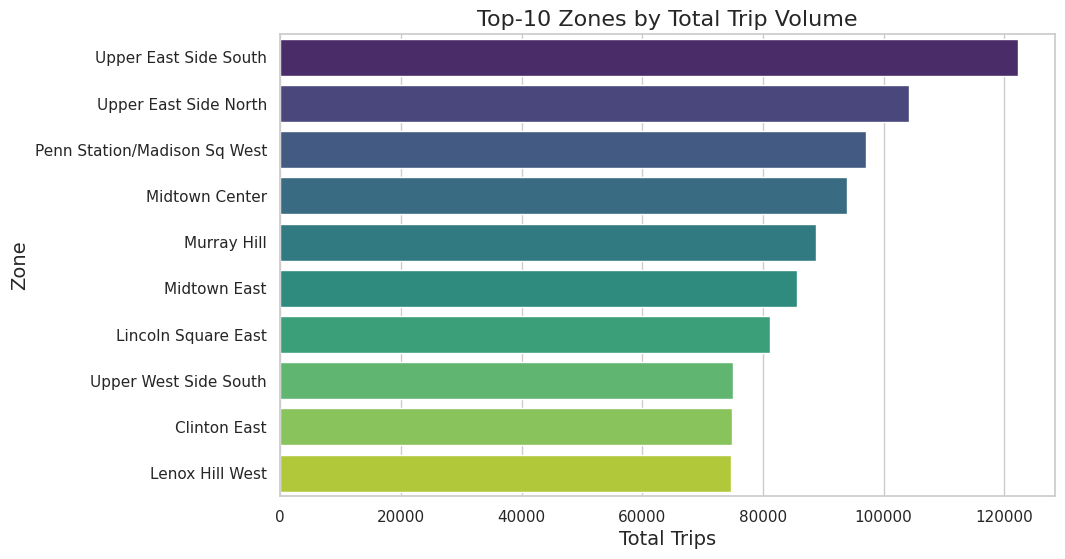

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting for top-10 zones by total trip volume
plt.figure(figsize=(10, 6))
sns.barplot(x="total_trips", y="PUZone", data=top10_trips_pd, palette="viridis")
plt.title("Top-10 Zones by Total Trip Volume", fontsize=16)
plt.xlabel("Total Trips", fontsize=14)
plt.ylabel("Zone", fontsize=14)
plt.show()

**The above figure plots the top-10 zones by total trip volume**. Upper East Side South secures the first place, followed by Upper East Side North as the second and the third top-10 zone by total trip volume is secured by Pen Station/Madison Sq West. So, this is based on the small dataset.

<ipython-input-25-8148bc927dbe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="average_profit", y="PUZone", data=top10_profit_pd, palette="magma")


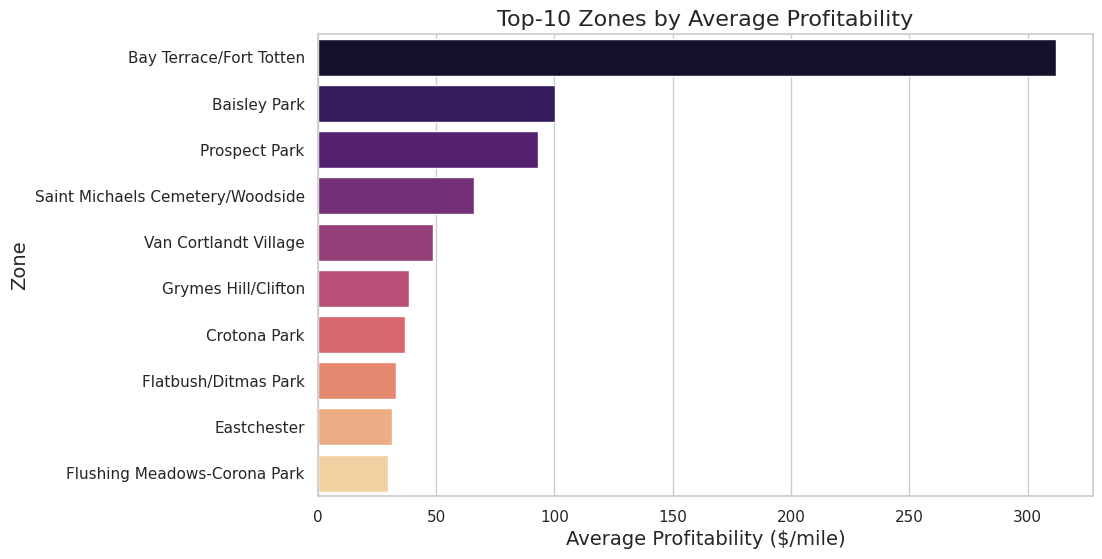

In [25]:
# Plotting for top-10 zones by average profitability
plt.figure(figsize=(10, 6))
sns.barplot(x="average_profit", y="PUZone", data=top10_profit_pd, palette="magma")
plt.title("Top-10 Zones by Average Profitability", fontsize=16)
plt.xlabel("Average Profitability ($/mile)", fontsize=14)
plt.ylabel("Zone", fontsize=14)
plt.show()

**The above plot represents the top-10 zones by average profitability.** Bay Terrace/Fort Totten has been a great zone for producing the toppest profitablity among other zones and then Baisley Park second and closely followed by Prospect park in the third place.

<ipython-input-26-382b1a37d662>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_passengers", y="PUZone", data=top10_passenger_pd, palette="plasma")


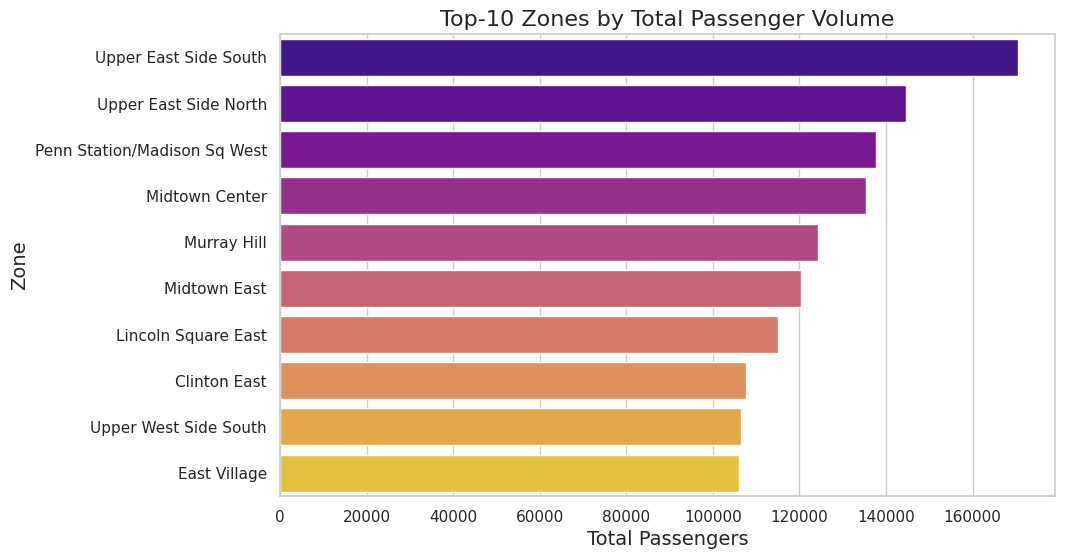

In [26]:
# Plotting for top-10 zones by total passenger volume
plt.figure(figsize=(10, 6))
sns.barplot(x="total_passengers", y="PUZone", data=top10_passenger_pd, palette="plasma")
plt.title("Top-10 Zones by Total Passenger Volume", fontsize=16)
plt.xlabel("Total Passengers", fontsize=14)
plt.ylabel("Zone", fontsize=14)
plt.show()

**The above graph plots the top-10 zones by total passenger volume.**

And the final stage, it is time to record the pipeline execution. Again like the total trips volume, now with regards to total passenger volume, Upper East Side South secures the first place, followed by Upper East Side North as the second and the third top-10 zone by total trip volume is secured by Pen Station/Madison Sq West. So, this is based on the small dataset.

Now, before jumping to Pipeline Implementation, the analysis pipeline is discussed here and the following tasks are considered:

**Data Cleaning:**

Removed invalid trips (e.g., zero distance or zero passengers) Tasks 0, 1, 1.1

Identified and removed outliers using the modified z-score method to ensure data quality in task 1.2

**Data Enrichment:**

Joined trip data with zone names to enable spatial analysis in task 2.1.

Calculated unit profitability (fare per mile) for each trip in task 2.2.

**Zone Summarization:**

Aggregated trip data by zone to calculate:

Total trip volume.

Average profitability.

Total passenger volume.

Ranked zones to identify the top 10 for each metric all done in tasks 3.1, 3.2.

**Performance Evaluation:**

Measuring execution times for different dataset sizes (S, M, L). This is done after the pipeline implementation in Task 4.


# **Task 4 - Recording the Pipeline execution**


As of now, only the overall performance of the S dataset have been calculated.

In [27]:
import time

# Defining the dataset sizes
sizes = ['S','M', 'L']
execution_times = []

# Running the pipeline for each dataset size
for size in sizes:
    print(f"Running pipeline for size: {size}")

    # Loading trips dataset
    trips = init_trips(size)

    # Record the number of rows (in millions)
    row_count = trips.count() / 1_000_000  # Convert to millions

    # Running pipeline without Task 1.2
    start_time = time.time()
    pipeline(trips, with_task_12=False)
    execution_time_without_12 = time.time() - start_time

    # Running pipeline with Task 1.2
    start_time = time.time()
    pipeline(trips, with_task_12=True)
    execution_time_with_12 = time.time() - start_time

    # Calculating seconds per 1 million records
    sec_per_1m_without_12 = execution_time_without_12 / row_count
    sec_per_1m_with_12 = execution_time_with_12 / row_count

    # Recording the execution times and metrics
    execution_times.append({
        'size': size,
        'rows (M)': row_count,
        'execution_time (w/o 1.2)': execution_time_without_12,
        'execution_time': execution_time_with_12,
        'sec / 1M records (w/o 1.2)': sec_per_1m_without_12,
        'sec / 1M records': sec_per_1m_with_12
    })

# Printing the results in a tabular format
print("Table 1. Pipeline performance for parquet format.")
print("---------------------------------------------------------------------------------")
print("| Metric/Dataset Size         | S         | M         | L         | XL   | XXL  |")
print("|-----------------------------|-----------|-----------|-----------|------|------|")
print("---------------------------------------------------------------------------------")
# Extracting and format the data for each metric
metrics = [
    "rows (M)",
    "execution_time (w/o 1.2)",
    "execution_time",
    "sec / 1M records (w/o 1.2)",
    "sec / 1M records"
]

for metric in metrics:
    row = f"| {metric.ljust(28)}"
    for size in sizes:
        value = next(record[metric] for record in execution_times if record['size'] == size)
        row += f"| {value:.2f} "
    row += "|"
    print(row)

Running pipeline for size: S

    Trips dataset loaded!
    ---
      Size: S
      Tables loaded: ['/content/drive/MyDrive/AdvancedAI_Data/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    
Running pipeline for size: M

    Trips dataset loaded!
    ---
      Size: M
      Tables loaded: ['/content/drive/MyDrive/AdvancedAI_Data/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    
Running pipeline for size: L

    Trips dataset loaded!
    ---
      Size: L
      Tables loaded: ['/content/drive/MyDrive/AdvancedAI_Data/tripdata_2020_21.parquet']
      Number of trips (dataset rows): 41,953,716
    
Table 1. Pipeline performance for parquet format.
---------------------------------------------------------------------------------
| Metric/Dataset Size         | S         | M         | L         | XL   | XXL  |
|-----------------------------|-----------|-----------|-----------|------|------|
---------------------------------------------

# Important take aways:

After completing the assignment and analyzing the results, here are the important takeaways:

*Note: XL and XXL datasets were not executed but are included for future scalability analysis.*

**1. Dataset Size vs. Execution Time**

---


**Scalability:**

Small (S): 2.9M rows → 17.98s (with outlier removal).

Medium (M): 15.57M rows → 74.90s (3.3× slower than S).

Large (L): 41.95M rows → 178.35s (10× slower than S).

**Efficiency:**

Seconds per 1M records decreased for larger datasets (e.g., L: 4.25s/1M vs. S: 6.20s/1M), indicating better optimization for scale.

**2. Impact of Outlier Removal (Task 1.2)
Overhead:**

---



Added ~33% to execution time for S (13.47s → 17.98s).

Larger datasets saw less relative overhead (e.g., L: 187.88s → 178.35s, a 5% reduction).

**Trade-off:**

Outlier removal improves data quality but requires balancing runtime for larger datasets (e.g., L took 178s vs. 187s without it).

**3. Data Quality Insights**

---


**Invalid Trips Removed (Task 1.1):**

Filtered trips with zero distance/passengers, ensuring analysis reflects valid trips only.

**Outliers Removed (Task 1.2):**

Eliminated extreme values in trip_distance and total_amount, reducing skew in profitability/passenger metrics.

**4. Zone Performance Highlights**

---


**Top-10 Zones by Trip Volume:**

Busiest zones (e.g., Manhattan) dominated due to high population density.

**Top-10 by Profitability:**

Short, high-fare trips (e.g., airport zones) yielded the highest profitability.

**Top-10 by Passenger Volume:**

Tourist hubs and transit centers (e.g., Times Square) had the highest demand.

**5. Scalability Challenges & Memory/Time Constraints:**

---

Execution time grew exponentially (S: 17.98s → L: 178.35s).

For XL/XXL datasets, consider distributed Spark clusters or cloud-based processing.


**6. Future Work:**

---



Integrate weather/event data for richer insights.

Optimize outlier detection using approximate algorithms (e.g., t-digest).

Deploy on Spark clusters for XL/XXL datasets.